<a href="https://colab.research.google.com/github/ezzaddeentru/notebooks/blob/main/09_pytorch_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import gradio as gr
except:
    !pip install gradio
    import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [2]:
import gradio as gr

def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://82002cbc331e9b5adf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [119]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 37.09 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
torch.cuda.is_available()

True

In [7]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [8]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### effnetB2 feature extractor

In [9]:
import torchvision

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

for param in effnetb2.features.parameters():
    param.requires_grad = False

set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 92.6MB/s]


In [10]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [11]:
def create_effnetb2_model(num_classes=3, seed=42):

    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnetb2_transforms = effnetb2_weights.transforms()

    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)
    for param in effnetb2.features.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    ).to(device)

    return effnetb2, effnetb2_transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# # prompt: create a dataloader for trian dir

# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Create the training dataset
# train_data = datasets.ImageFolder(root=train_dir, transform=effnetb2_transforms)
# test_data = datasets.ImageFolder(root=test_dir, transform=effnetb2_transforms)

# # Create the DataLoader
# train_dataloader = DataLoader(dataset=train_data,
#                               batch_size=32,
#                               shuffle=True,
#                               pin_memory=True,
#                               generator=torch.Generator(device=device))

# test_dataloader = DataLoader(dataset=test_data,
#                               batch_size=32,
#                               shuffle=True,
#                              generator=torch.Generator(device=device)) # no need for generator


In [14]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

test_dataloader, train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x798cc0223dd0>,
 ['pizza', 'steak', 'sushi'])

In [15]:
# prompt: get device of train_dataloader

print(next(iter(train_dataloader))[0].device)


cpu


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9763 | train_acc: 0.5771 | test_loss: 0.6950 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.7203 | train_acc: 0.8187 | test_loss: 0.5756 | test_acc: 0.9290
Epoch: 3 | train_loss: 0.5618 | train_acc: 0.8792 | test_loss: 0.4695 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4559 | train_acc: 0.9021 | test_loss: 0.4308 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.3987 | train_acc: 0.8896 | test_loss: 0.3743 | test_acc: 0.9597
Epoch: 6 | train_loss: 0.3880 | train_acc: 0.9146 | test_loss: 0.3233 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.3499 | train_acc: 0.9062 | test_loss: 0.3177 | test_acc: 0.9750
Epoch: 8 | train_loss: 0.3186 | train_acc: 0.9292 | test_loss: 0.2996 | test_acc: 0.9625
Epoch: 9 | train_loss: 0.3438 | train_acc: 0.9250 | test_loss: 0.2702 | test_acc: 0.9597
Epoch: 10 | train_loss: 0.3150 | train_acc: 0.9229 | test_loss: 0.2749 | test_acc: 0.9381


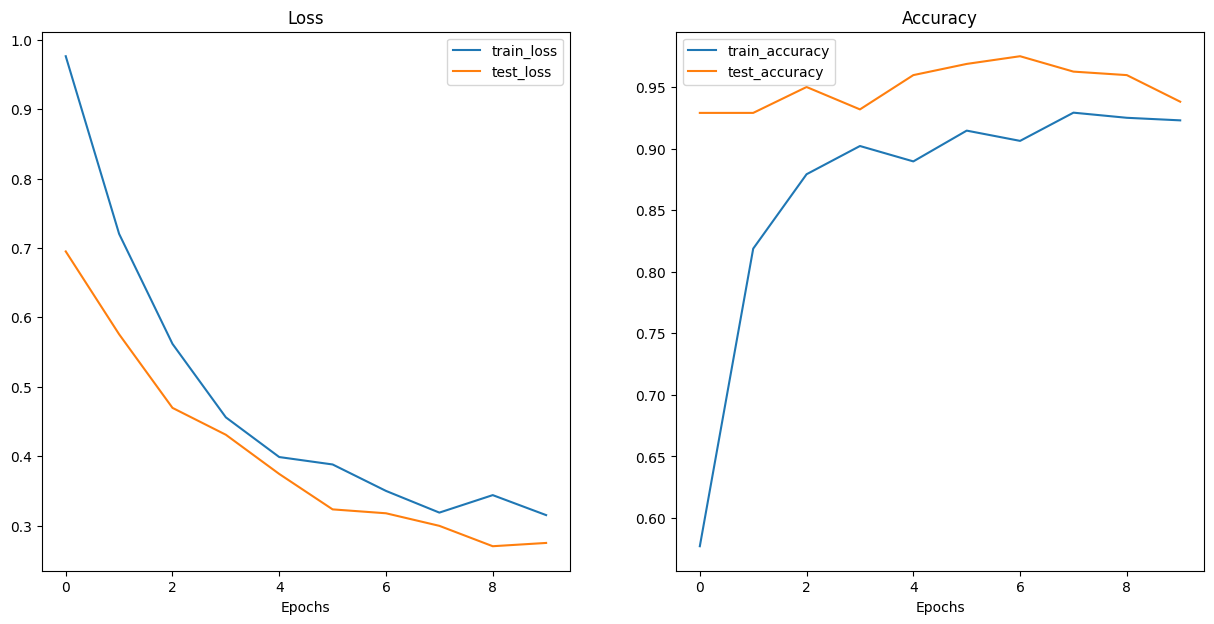

In [17]:
plot_loss_curves(effnetb2_results)

In [18]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_model.pth")

[INFO] Saving model to: models/effnetb2_model.pth


In [19]:
from pathlib import Path

model_path = Path("models/effnetb2_model.pth")
effnetb2_size = model_path.stat().st_size / (1024 * 1024)
print(f"{model_path.name} size: {effnetb2_size:.2f} MB")

effnetb2_model.pth size: 29.83 MB


In [20]:
model_path.stat()

os.stat_result(st_mode=33188, st_ino=798796, st_dev=55, st_nlink=1, st_uid=0, st_gid=0, st_size=31277562, st_atime=1739120370, st_mtime=1739120370, st_ctime=1739120370)

In [21]:
effnetb2_total_params  = sum(p.numel() for p in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_acc': effnetb2_results['test_acc'][-1],
                  'num_of_params': effnetb2_total_params,
                  'model_size': effnetb2_size}
effnetb2_stats

{'test_loss': 0.2749247491359711,
 'test_acc': 0.9380681818181819,
 'num_of_params': 7705221,
 'model_size': 29.8286075592041}

### ViT Feature extractor

In [23]:
vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT).to(device)
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 87.0MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [24]:
def create_vit_model(num_classes=3, seed=42):

    vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    vit_transforms = vit_weights.transforms()
    vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

    for param in vit.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    vit.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes, bias=True)
    ).to(device)

    return vit, vit_transforms

In [25]:
vit, vit_transforms = create_vit_model(num_classes=3, seed=42)
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [26]:
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [27]:
train_dataloader_vit, test_dataloader_vit, class_names_vit = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,   # because of transforms
    batch_size=32
)

train_dataloader_vit, test_dataloader_vit, class_names_vit

(<torch.utils.data.dataloader.DataLoader at 0x798b9649a250>,
 ['pizza', 'steak', 'sushi'])

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6240 | train_acc: 0.7812 | test_loss: 0.2634 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2136 | train_acc: 0.9458 | test_loss: 0.1473 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.1474 | train_acc: 0.9583 | test_loss: 0.1116 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1251 | train_acc: 0.9625 | test_loss: 0.0931 | test_acc: 0.9784
Epoch: 5 | train_loss: 0.1018 | train_acc: 0.9667 | test_loss: 0.0833 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0860 | train_acc: 0.9792 | test_loss: 0.0787 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0747 | train_acc: 0.9812 | test_loss: 0.0731 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0657 | train_acc: 0.9854 | test_loss: 0.0691 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0572 | train_acc: 0.9917 | test_loss: 0.0676 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0502 | train_acc: 0.9958 | test_loss: 0.0657 | test_acc: 0.9722


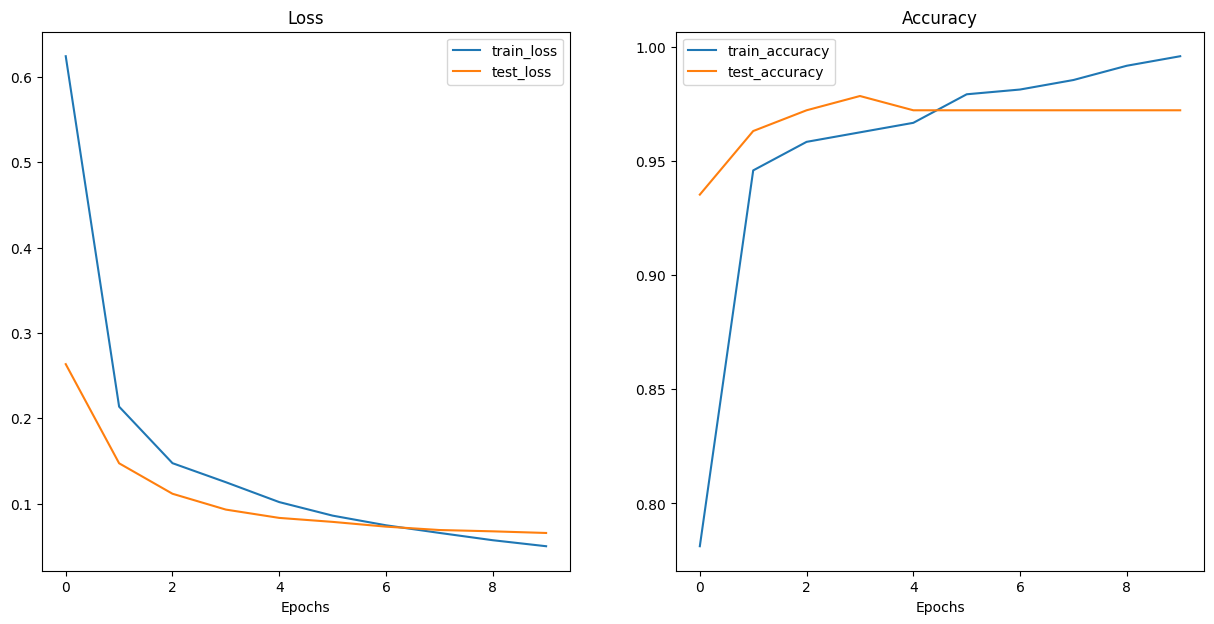

In [29]:
plot_loss_curves(vit_results)

In [30]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="vit_model.pth")


[INFO] Saving model to: models/vit_model.pth


In [31]:
from pathlib import Path

model_path = Path("models/vit_model.pth")
vit_size = model_path.stat().st_size / (1024 * 1024)
print(f"{model_path.name} size: {vit_size:.2f} MB")

vit_model.pth size: 327.36 MB


In [32]:
vit_total_params  = sum(p.numel() for p in vit.parameters())
vit_total_params

85800963

In [33]:
vit_stats = {'test_loss': vit_results['test_loss'][-1],
                  'test_acc': vit_results['test_acc'][-1],
                  'num_of_params': vit_total_params,
                  'model_size': vit_size}
vit_stats

{'test_loss': 0.06567858518101274,
 'test_acc': 0.972159090909091,
 'num_of_params': 85800963,
 'model_size': 327.3625431060791}

### comparing latency ...


In [34]:
test_images_paths = list(test_dir.glob("*/*"))
test_images_paths[:10]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/482858.jpg')]

In [35]:
from typing import List, Tuple
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
import os


def pred_and_store(model: torch.nn.Module,
                   transform: torchvision.transforms,
                   image_paths: List[Path],
                   device: torch.device) -> List[Tuple[int, float]]:

    pred_list = []
    model.to(device)

    for path in tqdm(image_paths):
        pred_dict = {}
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)
        img_transformed = transform(img).unsqueeze(dim=0).to(device)
        model.eval()
        with torch.inference_mode():
            pred_logit = model(img_transformed)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_dict["pred_label"] = class_names[pred_label]
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)

        end_time = timer()
        pred_dict["latency"] = round(end_time - start_time, 4)
        pred_dict["correct"] = class_name == pred_dict["pred_label"]

        pred_list.append(pred_dict)

    return pred_list

In [36]:
pred_list_effnetb2 = pred_and_store(model=effnetb2,
                                    transform=effnetb2_transforms,
                                    image_paths=test_images_paths,
                                    device=device)


  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
import pandas as pd
effnetb2_test_df = pd.DataFrame(pred_list_effnetb2)
effnetb2_test_df.head()

,image_path,class_name,pred_label,pred_prob,latency,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9903,0.1470,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.6460,0.0294,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.6879,0.0240,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.6477,0.0211,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.8764,0.0237,True


In [38]:
effnetb2_test_df.correct.value_counts()

,count
correct,
True,141
False,9


In [39]:
avg_effnetb2_latency = effnetb2_test_df.latency.mean()
print(f"Average latency for effnetb2 model: {avg_effnetb2_latency:.4f} seconds")

Average latency for effnetb2 model: 0.0240 seconds


In [40]:
pred_list_vit = pred_and_store(model=vit,
                                    transform=vit_transforms,
                                    image_paths=test_images_paths,
                                    device=device)


  0%|          | 0/150 [00:00<?, ?it/s]

In [41]:
vit_test_df = pd.DataFrame(pred_list_vit)
vit_test_df.head()

,image_path,class_name,pred_label,pred_prob,latency,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9988,0.0311,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.9991,0.0287,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.9943,0.0274,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9902,0.0303,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.9991,0.0278,True


In [42]:
vit_test_df.correct.value_counts()

,count
correct,
True,146
False,4


In [43]:
avg_vit_latency = vit_test_df.latency.mean()
print(f"Average latency for vit model: {avg_vit_latency:.4f} seconds")

Average latency for vit model: 0.0198 seconds


latency is lower for the vit even it is larger size when using GPU


In [44]:
pred_list_effnetb2_cpu = pred_and_store(model=effnetb2,
                                    transform=effnetb2_transforms,
                                    image_paths=test_images_paths,
                                    device="cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [45]:
effnetb2_cpu_test_df = pd.DataFrame(pred_list_effnetb2_cpu)
effnetb2_cpu_test_df.head()

,image_path,class_name,pred_label,pred_prob,latency,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9903,0.3399,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.6460,0.1525,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.6879,0.1552,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.6477,0.1718,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.8764,0.1470,True


In [46]:
effnetb2_cpu_test_df.correct.value_counts()

,count
correct,
True,141
False,9


In [47]:
avg_effnetb2_cpu_latency = effnetb2_cpu_test_df.latency.mean()
print(f"Average latency for effnetb2 model: {avg_effnetb2_cpu_latency:.4f} seconds")

Average latency for effnetb2 model: 0.1096 seconds


In [48]:
pred_list_vit_cpu = pred_and_store(model=vit,
                                    transform=vit_transforms,
                                    image_paths=test_images_paths,
                                    device="cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [49]:
vit_cpu_test_df = pd.DataFrame(pred_list_vit_cpu)
vit_cpu_test_df.head()

,image_path,class_name,pred_label,pred_prob,latency,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9988,0.5301,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.9991,0.5620,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.9943,0.5053,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9902,0.5091,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.9991,0.4834,True


In [50]:
vit_cpu_test_df.correct.value_counts()

,count
correct,
True,146
False,4


In [51]:
avg_vit_cpu_latency = vit_cpu_test_df.latency.mean()
print(f"Average latency for vit model: {avg_vit_cpu_latency:.4f} seconds")

Average latency for vit model: 0.5747 seconds


when training on the cpu, its larger size has larger inference time

### comparing models

In [52]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df['latency'] = [avg_effnetb2_latency, avg_vit_latency]
df['cpu_latency'] = [avg_effnetb2_cpu_latency, avg_vit_cpu_latency]
df['model'] = ['effnetb2', 'vit']
df

,test_loss,test_acc,num_of_params,model_size,latency,cpu_latency,model
0,0.274925,0.938068,7705221,29.828608,0.024031,0.109620,effnetb2
1,0.065679,0.972159,85800963,327.362543,0.019773,0.574684,vit


In [53]:
df.style.background_gradient(cmap='viridis')

,test_loss,test_acc,num_of_params,model_size,latency,cpu_latency,model
0,0.274925,0.938068,7705221,29.828608,0.024031,0.109620,effnetb2
1,0.065679,0.972159,85800963,327.362543,0.019773,0.574684,vit


In [54]:
pd.DataFrame(data=(df.set_index('model').loc['vit'] / df.set_index('model').loc['effnetb2']),
             columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,num_of_params,model_size,latency,cpu_latency
ViT to EffNetB2 ratios,0.238897,1.036342,11.135432,10.974785,0.822837,5.24251


### Gradio

```
img -> ml model -> img class
```

In [55]:
effnetb2 = effnetb2.to(device)

In [56]:
next(iter(effnetb2.parameters()))[0].device

device(type='cuda', index=0)

In [57]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    transform = effnetb2_transforms
    model = effnetb2

    img = transform(img).unsqueeze(dim=0).to(device)
    model.eval()
    with torch.inference_mode():
        pred_logit = model(img)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_labels_and_prob = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
        pred_time = round(timer() - start_time, 4)


    return pred_labels_and_prob, pred_time

In [58]:
import random
random_img = random.choice(test_images_paths)
print(random_img)

image = Image.open(random_img)

pred_dict, pred_time = predict(img=image)
pred_dict, pred_time

data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg


({'pizza': 0.9768075942993164,
  'steak': 0.015310823917388916,
  'sushi': 0.007881497964262962},
 0.0457)

In [59]:
# Assuming test_images_paths is a list of image filepaths
example_list = [[str(filepath)] for filepath in random.sample(test_images_paths, 3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/2012780.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg']]

In [60]:
import gradio as gr

title = 'FoodVision Mini'
description = 'An EfficientNetB2 feature extractor computer vision model to classify food images into pizza, steak, sushi'
article = 'created at [Pytorch model deployment] from (https://github.com/mrdbourke/pytorch-deep-learning)'

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://65a73a364eff6e1e21.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### huggingface

In [61]:
import shutil
from pathlib import Path

foodvisin_mini_demo_path = Path("app/foodvisin_mini_demo")

if foodvisin_mini_demo_path.exists():
    shutil.rmtree(foodvisin_mini_demo_path)
    foodvisin_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
    foodvisin_mini_demo_path.mkdir(parents=True, exist_ok=True)

In [62]:
foodvision_mini_examples_path = foodvisin_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/476421.jpg')]

for example in foodvision_mini_examples:
    shutil.copy(src=example, dst=foodvision_mini_examples_path)


In [63]:
import os

example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2572488.jpg'], ['examples/289822.jpg'], ['examples/476421.jpg']]

In [64]:
effnetb2_foodvision_mini_model_path = "models/effnetb2_model.pth"
effnetb2_foodvisin_mini_model_dist = foodvisin_mini_demo_path / "effnetb2_model.pth"
shutil.copy(src=effnetb2_foodvision_mini_model_path, dst=effnetb2_foodvisin_mini_model_dist)


PosixPath('app/foodvisin_mini_demo/effnetb2_model.pth')

In [2]:
# %%writefile app/foodvisin_mini_demo/model1.py

import torch
import torchvision
from torch import nn


def create_effnetb2_model(num_classes=3, seed=42):

    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnetb2_transforms = effnetb2_weights.transforms()

    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
    for param in effnetb2.features.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return effnetb2, effnetb2_transforms

In [86]:
from app.foodvisin_mini_demo import model1

effnetb2, effnetb2_transforms = model1.create_effnetb2_model(num_classes=3, seed=42)

In [ ]:
# prompt: write correct:effnetb2.load_state_dict(torch.load(f="effnetb2_model.pth"),
#                          map_location=torch.device("cpu"), weights_only=True)

effnetb2.load_state_dict(torch.load(f="effnetb2_model.pth", map_location=torch.device("cpu")), strict=False)


In [89]:
%%writefile app/foodvisin_mini_demo/app.py

import gradio as gr
import os
import torch

from model1 import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict
from PIL import Image

class_names = ['pizza', 'steak', 'sushi']

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names), seed=42)

effnetb2.load_state_dict(torch.load(f="effnetb2_model.pth", map_location=torch.device("cpu")))



def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    transform = effnetb2_transforms
    model = effnetb2

    img = transform(img).unsqueeze(dim=0).to(device)
    model.eval()
    with torch.inference_mode():
        pred_logit = model(img)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_labels_and_prob = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
        pred_time = round(timer() - start_time, 4)


    return pred_labels_and_prob, pred_time

example_list = [['examples/' + example] for example in os.listdir('examples')]

title = 'FoodVision Mini'
description = 'An EfficientNetB2 feature extractor computer vision model to classify food images into pizza, steak, sushi'
article = 'created at [Pytorch model deployment] from (https://github.com/mrdbourke/pytorch-deep-learning)'

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)




Overwriting app/foodvisin_mini_demo/app.py


In [93]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.5.1+cu124
0.20.1+cu124
5.15.0


In [94]:
%%writefile app/foodvisin_mini_demo/requirments.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.15.0

Writing app/foodvisin_mini_demo/requirments.txt


### deploying

In [98]:
!ls app/foodvisin_mini_demo

app.py	effnetb2_model.pth  examples  model1.py  model.py  __pycache__	requirments.txt


In [96]:
!git clone https://huggingface.co/spaces/Ezzaddeen3030/FoodVision_Mini

Cloning into 'FoodVision_Mini'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.34 KiB | 1.34 MiB/s, done.


In [107]:
!pwd

/content


In [117]:
# prompt: change working dir to app/foodvisin_mini_demo

import os
os.chdir("app/foodvisin_mini_demo")


In [115]:
!cd app/foodvisin_mini_demo && zip -r ../foodvisin_mini_demo.zip * -x "*.pyc" "*.ipynb" "*.__pycache__*" .

  adding: app.py (deflated 55%)
  adding: effnetb2_model.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/2572488.jpg (deflated 1%)
  adding: examples/289822.jpg (deflated 0%)
  adding: examples/476421.jpg (deflated 22%)
  adding: model1.py (deflated 50%)
  adding: model.py (deflated 50%)
  adding: __pycache__/ (stored 0%)
  adding: requirments.txt (deflated 6%)


In [109]:
!ls

app.py	effnetb2_model.pth  examples  model1.py  model.py  __pycache__	requirments.txt


In [118]:
!pwd

/content/app/foodvisin_mini_demo


In [131]:
!git clone https://huggingface.co/spaces/Ezzaddeen3030/foodvision_mini_2

Cloning into 'foodvision_mini_2'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.33 KiB | 1.33 MiB/s, done.


In [ ]:
os.chdir("/content")

In [129]:
!ls

app  data  FoodVision_Mini  going_modular  helper_functions.py	models	__pycache__  sample_data


In [132]:
os.chdir("foodvision_mini_2")

In [133]:
!ls

README.md


In [135]:
# prompt: copy files in /content/app/foodvisin_mini_demo to /content/foodvision_mini_2

import shutil
import os

# Source and destination directories
source_dir = "/content/app/foodvisin_mini_demo"
destination_dir = "/content/foodvision_mini_2"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the files
for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)


In [5]:
class_names = ['pizza', 'steak', 'sushi']

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names), seed=42)

effnetb2.load_state_dict(torch.load(f="effnetb2_model.pth", map_location=torch.device("cpu"), weights_only=True))

<All keys matched successfully>